In [1]:

import os
import sys
import numpy as np
import pandas as pd
import asyncio
import datetime
from tensorflow.keras.models import load_model # type: ignore
from tensorflow import keras
keras.config.enable_unsafe_deserialization()
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
import ta

# Add your project path
sys.path.append("/home/hamza-berrada/Desktop/cooding/airflow/airflow/pluggings/Live-Tools-V2")
from utilities.bitget_perp import PerpBitget
from strategies.nvp.embadding import generate_feature_vectors
from strategies.nvp.transformer_model import generate_additional_features, PositionalEncoding

def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)
import numpy as np

def smooth_and_rescale_predictions(predictions, actual, sequence_length=150, window_size=5):
    """
    Smooths the predictions using a moving average and rescales them to align with the actual values.
    
    Parameters:
    - predictions (array-like): The predicted values.
    - actual (array-like): The actual values corresponding to the predictions.
    - sequence_length (int): The length of the initial sequence to use for rescaling.
    - window_size (int): The window size for the moving average smoothing.
    
    Returns:
    - smoothed_rescaled_predictions (array-like): The smoothed and rescaled predictions.
    """
    # Step 1: Smooth the predictions using a moving average
    def moving_average(data, window):
        return np.convolve(data, np.ones(window)/window, mode='valid')
    
    smoothed_predictions = moving_average(predictions, window_size)
    
    # Step 2: Rescale the predictions to align with the actual values over the first sequence_length
    if len(actual) < sequence_length or len(smoothed_predictions) < sequence_length:
        raise ValueError("The sequence length for rescaling is larger than the available data.")
    
    # Calculate the scaling factor based on the ratio of actual to predicted over the first sequence_length
    scaling_factor = np.mean(actual[:sequence_length]) / np.mean(smoothed_predictions[:sequence_length])
    
    # Apply the scaling factor to the smoothed predictions
    smoothed_rescaled_predictions = smoothed_predictions * scaling_factor
    
    # Pad the rescaled predictions to match the original length (since smoothing reduces the array size)
    padding_length = len(predictions) - len(smoothed_rescaled_predictions)
    smoothed_rescaled_predictions = np.pad(smoothed_rescaled_predictions, (padding_length, 0), mode='edge')
    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual')
    plt.plot(smoothed_rescaled_predictions, label='Smoothed and Rescaled Predicted', color='orange')
    plt.title('BTC Actual vs. Smoothed and Rescaled Predicted Close Prices')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def plot_predictions(y_true, y_pred, scaler, feature_index=3):
    """
    Plot the actual vs. predicted values for a specific feature over multiple time steps.

    Parameters:
    - y_true: Actual values, shape (num_samples, output_steps, num_features)
    - y_pred: Predicted values, shape (num_samples, output_steps, num_features)
    - scaler: Scaler used to normalize the data.
    - feature_index: Index of the feature to plot (e.g., 3 for 'close' price).
    """

    # Reshape to 2D arrays
    y_true_flat = y_true.reshape(-1, y_true.shape[-1])
    y_pred_flat = y_pred.reshape(-1, y_pred.shape[-1])

    # Inverse transform to original scale
    y_true_inv = scaler.inverse_transform(y_true_flat)
    y_pred_inv = scaler.inverse_transform(y_pred_flat)

    y_true_feature = y_true_inv[:, feature_index]
    y_pred_feature = y_pred_inv[:, feature_index]

    plt.figure(figsize=(12, 6))
    plt.plot(y_true_feature, label='Actual')
    plt.plot(y_pred_feature, label='Predicted')
    plt.title('BTC Actual vs. Predicted Close Prices')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def plot_raw_data(df, feature_column='close'):
    """
    Plot the raw data from the exchange for a specific feature.

    Parameters:
    - df: DataFrame containing the raw data.
    - feature_column: The column to plot (default is 'close').
    """
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[feature_column], label='Raw Data')
    plt.title(f'BTC {feature_column.capitalize()} Price from Exchange')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()





2024-10-27 12:08:17.851221: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-27 12:08:17.853207: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-27 12:08:17.875588: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-27 12:08:17.949663: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730045298.099775  747217 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730045298.15

In [55]:
# Load the transformer model and scaler
model = load_model('/home/hamza-berrada/Desktop/cooding/airflow/transformer_model_checkpoint.keras', custom_objects={'PositionalEncoding': PositionalEncoding})
scaler = joblib.load('/home/hamza-berrada/Desktop/cooding/airflow/scaler.save')

# Initialize the exchange
exchange = PerpBitget()
await exchange.load_markets()

# Select the BTC/USDT pair
pair = 'BTC/USDT'

# Fetch the latest OHLCV data for BTC
timeframe = '1h'
limit = 300
df = await exchange.get_last_ohlcv(pair, timeframe, limit)
await exchange.close()

# Check if 'timestamp' column exists, create one if not
if "timestamp" not in df.columns:
    # Create a timestamp starting from current time, decrementing by 1 hour
    now = datetime.datetime.now()
    timestamps = [
        now - datetime.timedelta(hours=(len(df) - i - 1)) for i in range(len(df))
    ]
    df["timestamp"] = timestamps
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
    
df.index = df["timestamp"]
# Generate feature vectors
feature_vectors, feature_columns = generate_feature_vectors(df)

# Generate additional features
df = generate_additional_features(df)
additional_features = [
    "hour",
    "day_of_week",
    "is_weekend",
    "macd",
    "stochastic",
    "bollinger_mavg",
    "bollinger_hband",
    "bollinger_lband",
]
additional_feature_vectors = df[additional_features].values

# Combine original and additional features
feature_vectors = np.concatenate(
    (feature_vectors, additional_feature_vectors), axis=1
)
# Scaling
feature_vectors_scaled = scaler.transform(feature_vectors)
# Define sequence length and output steps
output_steps = 5  # Number of future steps predicted

# Create sequences
sequence_length = 150
x = []
x.append(feature_vectors_scaled[0 :  sequence_length])
x = np.array(x)

predictions = model.predict(x)
# Get the actual values for comparison
y_true = []
for i in range(sequence_length, len(feature_vectors_scaled) - output_steps + 1):
    y_true.append(feature_vectors_scaled[i : i + output_steps])
y_true = np.array(y_true)

# Ensure y_true and predictions have the same length
min_len = min(len(y_true), len(predictions))
y_true = y_true[:min_len]
predictions = predictions[:min_len]

# Reshape predictions and y_true to 2D
y_true_flat = y_true.reshape(-1, y_true.shape[-1])
predictions_flat = predictions.reshape(-1, predictions.shape[-1])

    # Inverse transform to original scale
y_true_inv = scaler.inverse_transform(y_true_flat)
predictions_inv = scaler.inverse_transform(predictions_flat)

# Extract the 'close' prices (assuming 'close' is at index 3)
y_true_close = y_true_inv[:, 3]
predictions_close = predictions_inv[:, 3]

# Smooth and rescale predictions
# smooth_and_rescale_predictions(predictions_close, y_true_close, sequence_length=150, window_size=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


ValueError: The sequence length for rescaling is larger than the available data.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━

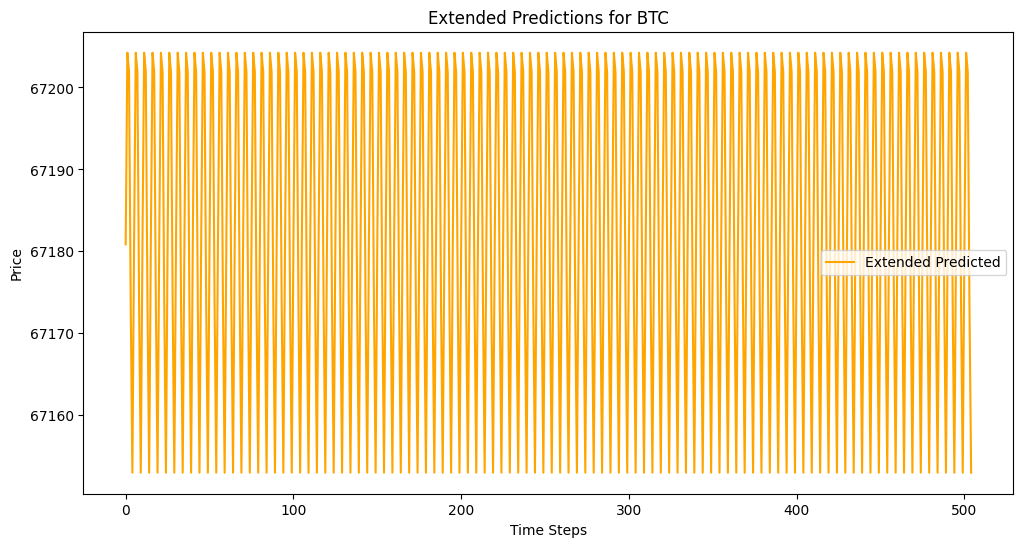

In [80]:
# Initial prediction to get the first 5 future points
predictions = model.predict(x)

# Number of iterations needed to extend the forecast
num_iterations = 100  # For example, to predict 50 steps in total (5 steps per iteration)

# Store all the predictions
all_predictions = [predictions[0]]  # Start with the initial prediction

# Iteratively predict the next steps based on previous predictions
for i in range(num_iterations):
    # Update x[0] by removing the first 5 elements and appending the current predictions
    x[0] = np.concatenate((x[0][5:], predictions[0]), axis=0)
    
    # Predict the next 5 points using the updated sequence
    predictions = model.predict(x)
    
    # Store the new predictions
    all_predictions.append(predictions[0])

# Concatenate all the predicted segments into a single array
all_predictions = np.concatenate(all_predictions, axis=0)
all_predictions_scaled = scaler.inverse_transform(all_predictions)
# Plotting the extended predictions
plt.figure(figsize=(12, 6))
plt.plot(range(len(all_predictions_scaled)), all_predictions_scaled[:, 3], label='Extended Predicted', color='orange')  # Assuming index 3 is 'close' price
plt.title('Extended Predictions for BTC')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

In [81]:
print(predictions)

# print(scaler.inverse_transform(predictions))

[[[ 0.63919854  0.61469805  0.6351911   0.62156785 -0.673633
   -0.09827983 -0.61226267 -0.79149246 -0.46792138  0.6313148
    0.6433793   0.01577359 -0.70191073 -0.72989786  0.71789116
   -0.45639637 -0.05394542 -0.35933432  0.64784855  0.4758171
    0.7233978 ]
  [ 0.6459655   0.6231393   0.63814735  0.63356817 -0.6499622
   -0.11592312 -0.5943514  -0.7815717  -0.45689374  0.64060974
    0.64395845 -0.01851952 -0.69441265 -0.7422017   0.76491624
   -0.44840214 -0.0599798  -0.3514147   0.64455074  0.4663056
    0.7307194 ]
  [ 0.6384746   0.58789694  0.6293308   0.63236344 -0.6691449
   -0.1090055  -0.5809809  -0.7740522  -0.43350145  0.63976073
    0.6402108  -0.02475137 -0.7276948  -0.73995733  0.74565095
   -0.47139275 -0.05809021 -0.37837115  0.6710332   0.48716795
    0.7182228 ]
  [ 0.646454    0.56701875  0.6381756   0.6178066  -0.6694772
   -0.07477796 -0.55579126 -0.765804   -0.39992854  0.6421744
    0.64517206 -0.01142278 -0.7113495  -0.7468491   0.7422606
   -0.46785334 -0

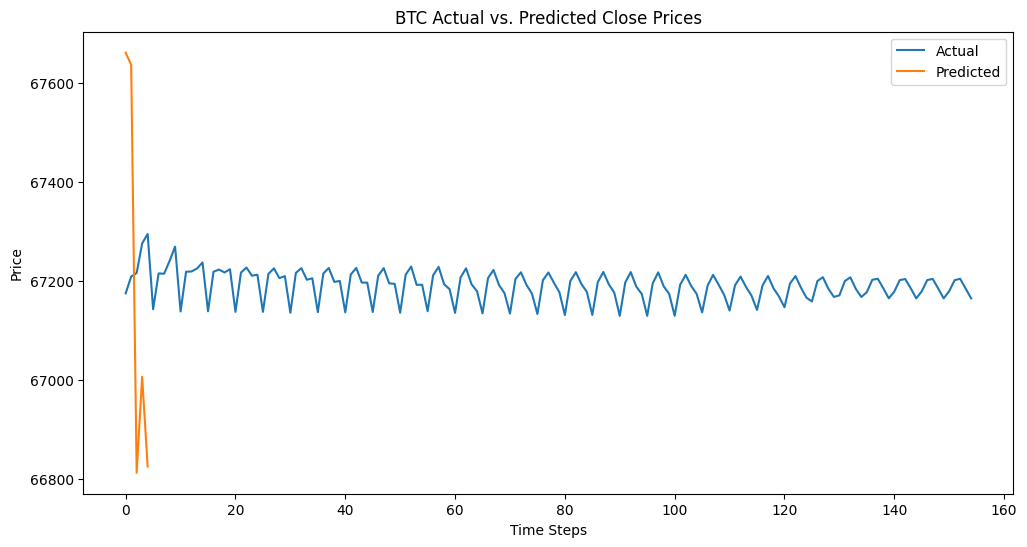

In [75]:
plot_predictions(predictions,y_true,scaler,3)

In [54]:
return_value = scaler.inverse_transform(x[0])
print(return_value[-2],'\n',return_value[-1])

[ 6.83046000e+04  6.84393000e+04  6.81426000e+04  6.83945000e+04
  2.96700000e+02  8.99000000e+01  1.00000000e+00  6.05206000e+04
  6.30674000e+04  6.88350000e+04  6.86830809e+04  4.59476927e+01
  3.21239414e+02  5.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.14315701e+02  1.80057184e+01  6.87529200e+04  6.92832092e+04
  6.82226308e+04] 
 [ 6.83945000e+04  6.84830000e+04  6.82780000e+04  6.82938000e+04
  2.05000000e+02 -1.00700000e+02  0.00000000e+00  6.05206000e+04
  6.30674000e+04  6.88014214e+04  6.86311767e+04  4.37361826e+01
  3.12936598e+02  6.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.22250240e+02  1.08077198e+01  6.87360400e+04  6.93010813e+04
  6.81709987e+04]
